In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score,
    recall_score, f1_score,
    silhouette_score, calinski_harabasz_score,
    davies_bouldin_score
)

In [145]:
churn = pd.read_csv(r"C:\Users\Administrator\Desktop\BEMM466/WA_Fn-UseC_-Telco-Customer-Churn.csv") # upload the dataset

In [146]:
# data clean
churn.columns = churn.columns.str.strip()
y = churn['Churn'].map({'Yes': 1, 'No': 0})
churn = churn.drop(columns=['customerID', 'Churn', 'gender', 'SeniorCitizen'])      #Delete invalid columns and potential biased fields

# Convert variables to numerical values and fill them with the average value
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors='coerce')
churn['TotalCharges'] = churn['TotalCharges'].fillna(churn['TotalCharges'].mean())

# Perform one code encoding
df_encoded = pd.get_dummies(churn, drop_first=True)

# Delete constant columns and highly correlated variables
nunique=df_encoded.nunique()
cols_to_drop =nunique[nunique == 1].index.tolist()
df_encoded = df_encoded.drop(columns=cols_to_drop)

corr_matrix = df_encoded.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)] 
df_encoded = df_encoded.drop(columns=to_drop_corr)    # Find columns with identical values and delete data


In [147]:
# Standardized features
scaler = StandardScaler()

# Only fit clustering on the training set; then apply it to the test set, placing it in data leakage.
X_all = df_encoded.copy()
X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(
    X_all, y, test_size=0.3, random_state=42, stratify=y)

# fit scaler on train only, then transform both
scaler.fit(X_train_tmp)
X_train_scaled = scaler.transform(X_train_tmp)
X_test_scaled  = scaler.transform(X_test_tmp)

# Reassemble the X_scaled data back into its original order and continue to store it under the variable name X_scaled.
X_scaled = np.empty_like(X_all.values, dtype=float)
X_scaled[X_all.index.get_indexer(X_train_tmp.index)] = X_train_scaled
X_scaled[X_all.index.get_indexer(X_test_tmp.index)]  = X_test_scaled
X_all = df_encoded.copy()
print(df_encoded.head())

   tenure  MonthlyCharges  TotalCharges  Partner_Yes  Dependents_Yes  \
0       1           29.85         29.85         True           False   
1      34           56.95       1889.50        False           False   
2       2           53.85        108.15        False           False   
3      45           42.30       1840.75        False           False   
4       2           70.70        151.65        False           False   

   PhoneService_Yes  MultipleLines_Yes  InternetService_Fiber optic  \
0             False              False                        False   
1              True              False                        False   
2              True              False                        False   
3             False              False                        False   
4              True              False                         True   

   InternetService_No  OnlineSecurity_Yes  ...  DeviceProtection_Yes  \
0               False               False  ...                 False

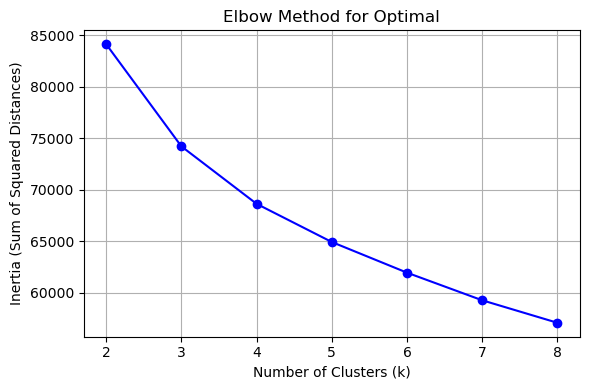

In [148]:
# Finding the optimal number of clusters
# Establish variables and prepare for modeling
inertias = []
K_range=range(2,9 )

# Establish and train a model, and record inertia values
for k in K_range:
    model=KMeans(n_clusters=k, random_state=42)
    # use on the train set only
    model.fit(X_train_scaled)
    inertias.append(model.inertia_)

# print the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal')
plt.grid(True)
plt.tight_layout()
plt.show()      # Use contour coefficients to determine the final number of clusters.
silhouette_scores = []
K_range = range(2, 11) 

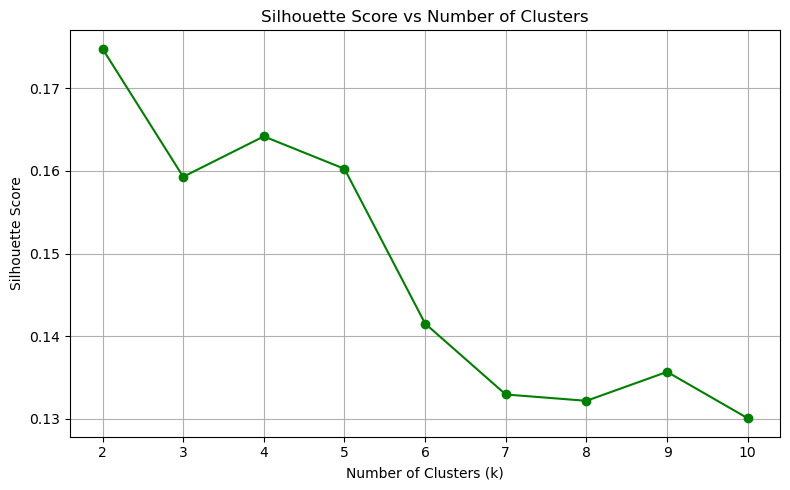

In [149]:
# Assign cluster labels to each sample and perform calculations.
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_train = kmeans.fit_predict(X_train_scaled)
    score = silhouette_score(X_train_scaled, labels_train)
    silhouette_scores.append(score)

# Draw pictures for visualization
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='green')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()# Run K-Means and GMM clustering analysis


In [150]:
# ADDED: KMeans/GMM：只在训练集拟合，再对全量样本做预测（训练集直接用labels_，测试集用predict）
kmeans_final = KMeans(n_clusters=4, random_state=42).fit(X_train_scaled)
labels_kmeans = np.empty(len(X_all), dtype=int)
labels_kmeans[X_all.index.get_indexer(X_train_tmp.index)] = kmeans_final.labels_
labels_kmeans[X_all.index.get_indexer(X_test_tmp.index)]  = kmeans_final.predict(X_test_scaled)

gmm_final = GaussianMixture(n_components=4, random_state=42).fit(X_train_scaled)
labels_gmm = np.empty(len(X_all), dtype=int)
labels_gmm[X_all.index.get_indexer(X_train_tmp.index)] = gmm_final.predict(X_train_scaled)
labels_gmm[X_all.index.get_indexer(X_test_tmp.index)]  = gmm_final.predict(X_test_scaled)


In [151]:
# Define clustering evaluation function
def evaluate_model(name, X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    print(f"\n {name} Cluster evaluation results：")
    print(f"  Silhouette Score : {sil:.4f}")
    print(f"  Calinski-Harabasz Index: {ch:.2f}")
    print(f"  Davies-Bouldin Index : {db:.4f}")
    return sil, ch, db

# print final outcome of the evaluation
# Here, we use the full X_scaled and the predicted full labels_ for extrapolation evaluation, while the fitting is still only done using the training set.
evaluate_model("KMeans", X_scaled, labels_kmeans)
evaluate_model("GMM", X_scaled, labels_gmm)# Copy a copy of the data with clustering results to avoid modifying the original data.
df_with_cluster = df_encoded.copy()
df_with_cluster['Cluster_KMeans'] = labels_kmeans

# Adding original business fields means more than just dummy variables.
df_with_cluster['tenure'] = churn['tenure'].values
df_with_cluster['MonthlyCharges'] = churn['MonthlyCharges'].values
df_with_cluster['Churn'] = y.values

contract_cols = [col for col in df_encoded.columns if col in ['Contract_One year', 'Contract_Two year']]
df_with_cluster['LongContract'] = df_encoded[contract_cols].sum(axis=1)      #Determine a new variable based on data from contract types.


 KMeans Cluster evaluation results：
  Silhouette Score : 0.1633
  Calinski-Harabasz Index: 1177.43
  Davies-Bouldin Index : 2.1789

 GMM Cluster evaluation results：
  Silhouette Score : 0.1684
  Calinski-Harabasz Index: 1067.81
  Davies-Bouldin Index : 1.9980


In [152]:
# Add fiber optic user mark
if 'InternetService_Fiber optic' in df_encoded.columns:
    df_with_cluster['FiberUser'] = df_encoded['InternetService_Fiber optic']
else:
    df_with_cluster['FiberUser'] = 0 

# Group by cluster. Calculate the average value for each cluster.
cluster_summary = df_with_cluster.groupby('Cluster_KMeans').agg({
    'tenure': 'mean','MonthlyCharges': 'mean',
    'LongContract': 'mean','FiberUser': 'mean',
    'Churn': 'mean','Cluster_KMeans': 'count'
}).rename(columns={
    'Cluster_KMeans': 'Count','Churn': 'Churn_Rate',
    'LongContract': 'LongContract_Rate','FiberUser': 
    'FiberUser_Rate'})

# Percentage conversion, enhanced readability
cluster_summary['Churn_Rate (%)'] = (cluster_summary['Churn_Rate'] * 100).round(1)
cluster_summary['LongContract (%)'] = (cluster_summary['LongContract_Rate'] * 100).round(1)
cluster_summary['FiberUser (%)'] = (cluster_summary['FiberUser_Rate'] * 100).round(1)
cluster_summary = cluster_summary.drop(columns=['Churn_Rate', 'LongContract_Rate', 'FiberUser_Rate'])   # Remove unnecessary intermediate columns# print the outcome
print("Five types of user profiles：")
print(cluster_summary)# Extract these five metrics from cluster_summary and standardize the data.
labels = ['Tenure','MonthlyCharges','Churn Rate','LongContract','FiberUser']
num_vars = len(labels)
data = cluster_summary[['tenure','MonthlyCharges','Churn_Rate (%)','LongContract (%)','FiberUser (%)']]
data_norm = (data - data.min()) / (data.max() - data.min())    


Five types of user profiles：
                   tenure  MonthlyCharges  Count  Churn_Rate (%)  \
Cluster_KMeans                                                     
0               59.066304       92.068207   1840            12.0   
1               17.862876       83.788438   2093            54.3   
2               22.301779       49.983513   1574            25.2   
3               30.480469       21.268132   1536             7.5   

                LongContract (%)  FiberUser (%)  
Cluster_KMeans                                   
0                           83.9           61.3  
1                            5.2           93.2  
2                           32.6            1.1  
3                           65.4            0.1  


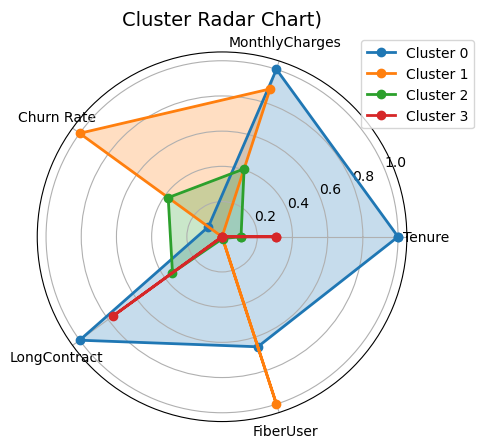

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, ...)

In [153]:
# Draw a radar chart
for i, (idx, row) in enumerate(data_norm.iterrows()):
    values= row.tolist()
    values+=values[:1]
    plt.polar(angles, values, marker='o', color=colors[i], linewidth=2, label=f'Cluster {idx}')
    plt.fill(angles, values, color=colors[i], alpha=0.25)

# Set tags to enrich chart details
plt.xticks(angles[:-1], labels)
plt.title("Cluster Radar Chart)", fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))
plt.show()# Train an XGBoost model on the entire sample
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y, test_size=0.3, random_state=42, stratify=y)

xgb_all = XGBClassifier(            # Train the overall XGBoost model
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1)
xgb_all.fit(X_train_all, y_train_all)

In [154]:
# Overall performance of the computational model
y_prob_all = xgb_all.predict_proba(X_test_all)[:, 1]
y_pred_all = (y_prob_all >= 0.5).astype(int)
metrics_all = {
    "Cluster": "ALL",
    "AUC": roc_auc_score(y_test_all, y_prob_all),
    "F1": f1_score(y_test_all, y_pred_all),
    "Accuracy": accuracy_score(y_test_all, y_pred_all),
    "Recall": recall_score(y_test_all, y_pred_all)}
# View subset sample cluster performance
labels_series = pd.Series(labels_kmeans, index=X_all.index, name="Cluster")
results = [metrics_all.copy()]

In [155]:
# Bootstrap CI + AUC, Accuracy, Recall, F1

def _bootstrap_ci_simple(values, alpha=0.05):
    lo = np.quantile(values, alpha/2)
    hi = np.quantile(values, 1 - alpha/2)
    return float(lo), float(hi)

# For each test set subsample of each cluster, calculate the point estimates and CIs of AUC/Accuracy/Recall/F1 separately.
def _bootstrap_metric_ci_simple(y_true, y_score, metric="AUC", n_boot=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    stats = []
    # baseline point estimate
    if metric == "AUC":
        point = roc_auc_score(y_true, y_score)
    elif metric == "Accuracy":
        point = accuracy_score(y_true, (y_score >= 0.5).astype(int))
    elif metric == "Recall":
        point = recall_score(y_true, (y_score >= 0.5).astype(int))
    elif metric == "F1":
        point = f1_score(y_true, (y_score >= 0.5).astype(int))
    else:
        raise ValueError("Unsupported metric")

    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        yt = y_true[idx]; ys = y_score[idx]
        if metric == "AUC":
            if yt.min() == yt.max():  # avoid single-class bootstrap sample
                continue
            s = roc_auc_score(yt, ys)
        elif metric == "Accuracy":
            s = accuracy_score(yt, (ys >= 0.5).astype(int))
        elif metric == "Recall":
            s = recall_score(yt, (ys >= 0.5).astype(int))
        elif metric == "F1":
            s = f1_score(yt, (ys >= 0.5).astype(int))
        stats.append(s)

    ci = _bootstrap_ci_simple(np.array(stats, dtype=float))
    return float(point), ci


# Run bootstrap on each of the four metrics of the entire test set and output the point estimate [lower bound, upper bound].
results_global = {}
for m in ["AUC", "Accuracy", "Recall", "F1"]:
    point, ci = _bootstrap_metric_ci_simple(y_test_all.values, y_prob_all, metric=m)
    results_global[m] = f"{point:.4f} [{ci[0]:.4f}, {ci[1]:.4f}]"

print("\nGlobal Results:")
for k,v in results_global.items():
    print(f"{k:<10}: {v}")


# For each test set subsample of each cluster, calculate the point estimates and CIs of AUC/Accuracy/Recall/F1 separately.
rows_ci = []
for cid in sorted(labels_series.unique()):
    mask = (labels_series == cid) & (labels_series.index.isin(test_idx))
    y_true_c = y.loc[mask].values
    if y_true_c.size == 0 or np.unique(y_true_c).size < 2:
        continue
    y_score_c = xgb_all.predict_proba(X_all.loc[mask])[:, 1]

    row = {"Cluster": f"Cluster {cid}"}
    for m in ["AUC", "Accuracy", "Recall", "F1"]:
        point, ci = _bootstrap_metric_ci_simple(y_true_c, y_score_c, metric=m)
        row[f"{m} (95% CI)"] = f"{point:.4f} [{ci[0]:.4f}, {ci[1]:.4f}]"
    rows_ci.append(row)

# Output four lines of text, each line containing one indicator and its range.
df_ci_simple = pd.DataFrame(rows_ci)
print("\nPer-cluster Results:")
print(df_ci_simple)


Global Results:
AUC       : 0.8335 [0.8145, 0.8513]
Accuracy  : 0.7899 [0.7719, 0.8079]
Recall    : 0.4795 [0.4386, 0.5202]
F1        : 0.5479 [0.5100, 0.5848]

Per-cluster Results:
     Cluster             AUC (95% CI)        Accuracy (95% CI)  \
0  Cluster 0  0.7501 [0.6878, 0.8025]  0.8826 [0.8532, 0.9083]   
1  Cluster 1  0.6902 [0.6510, 0.7294]  0.6276 [0.5911, 0.6640]   
2  Cluster 2  0.7789 [0.7315, 0.8265]  0.7827 [0.7447, 0.8207]   
3  Cluster 3  0.7949 [0.7171, 0.8667]  0.9093 [0.8834, 0.9352]   

           Recall (95% CI)              F1 (95% CI)  
0  0.0492 [0.0000, 0.1091]  0.0857 [0.0000, 0.1818]  
1  0.6540 [0.6029, 0.7033]  0.6549 [0.6127, 0.6943]  
2  0.3333 [0.2500, 0.4182]  0.4372 [0.3432, 0.5218]  
3  0.0769 [0.0000, 0.1667]  0.1250 [0.0000, 0.2535]  


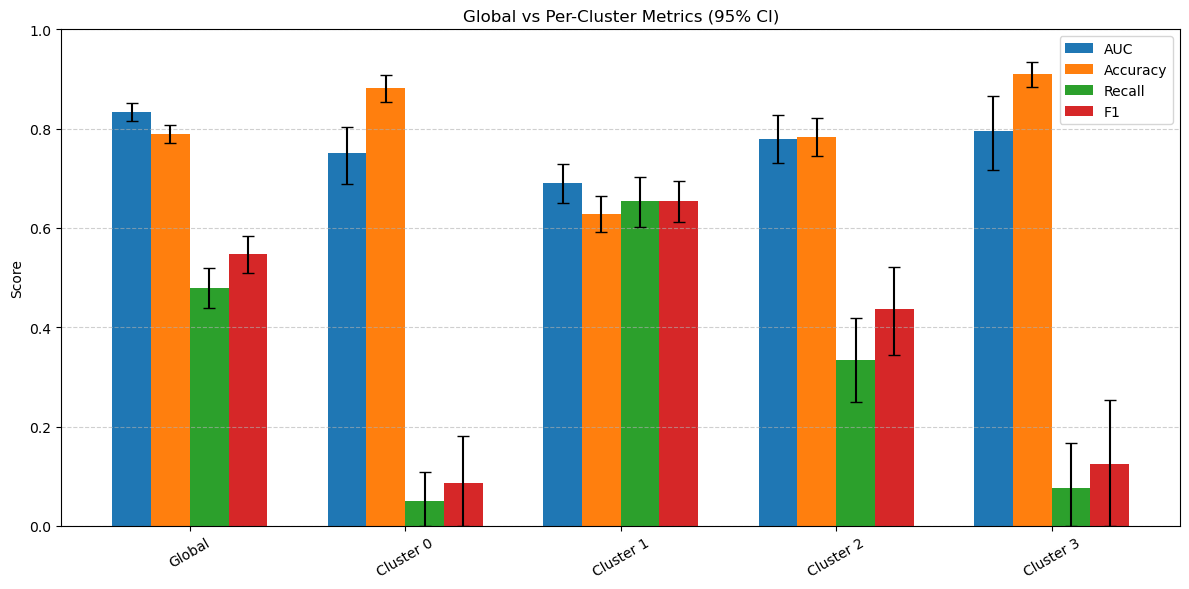

In [180]:
# Organise Global data
global_data = {
    "Cluster": ["Global"],
    "AUC (95% CI)": [results_global["AUC"]],
    "Accuracy (95% CI)": [results_global["Accuracy"]],
    "Recall (95% CI)": [results_global["Recall"]],
    "F1 (95% CI)": [results_global["F1"]]}
df_all = pd.concat([pd.DataFrame(global_data), df_ci_simple], ignore_index=True)

#Define the metrics to be plotted: AUC, Accuracy, Recall, F1. Set metrics and groups.
metrics = ["AUC", "Accuracy", "Recall", "F1"]
groups = df_all["Cluster"].tolist()
x = np.arange(len(groups))
width = 0.18

# Draw a bar chart
fig, ax = plt.subplots(figsize=(12,6))

for j, m in enumerate(metrics):
    pts, loe, hie = [], [], []
    for row in df_all[f"{m} (95% CI)"]:
        point = float(row.split()[0])
        lo = float(row.split("[")[1].split(",")[0])
        hi = float(row.split(",")[1].split("]")[0])
        pts.append(point)
        loe.append(point - lo)
        hie.append(hi - point)
    ax.bar(x + j*width - (len(metrics)-1)*width/2, pts, width=width,
           yerr=[loe, hie], capsize=4, label=m)

# Beautify charts to make their content easier to read
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=30)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Global vs Per-Cluster Metrics (95% CI)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


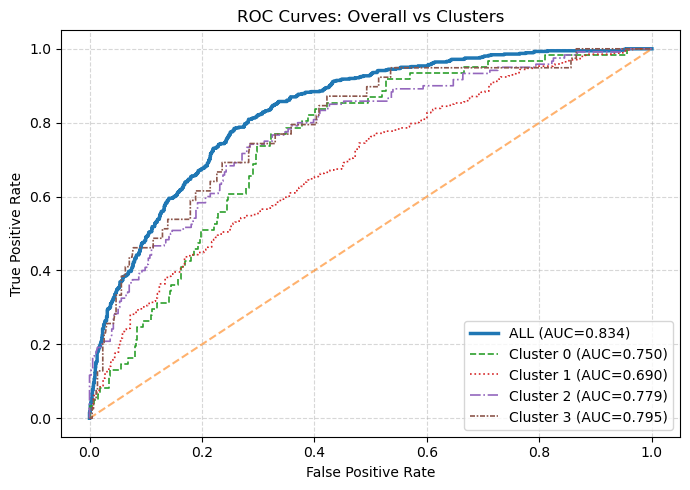

In [156]:
# Calculate the ROC curve for the entire sample
fpr_all, tpr_all, _ = roc_curve(y_test_all, y_prob_all)
auc_all = roc_auc_score(y_test_all, y_prob_all)

plt.figure(figsize=(7, 5))
plt.plot(fpr_all, tpr_all, label=f"ALL (AUC={auc_all:.3f})", linewidth=2.5)
plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.6)

# Drawing ROC curves for different line types
linestyles = ['--', ':', '-.', (0, (3, 1, 1, 1))]
test_idx = X_test_all.index

for i, cid in enumerate(sorted(labels_series.unique())):
    mask = (labels_series == cid) & (labels_series.index.isin(test_idx))
    y_true_c = y.loc[mask]
    if y_true_c.nunique() < 2:
        continue

    # Obtain probabilities on the test subset using the overall model
    y_prob_c = xgb_all.predict_proba(X_all.loc[mask])[:, 1]
    fpr_c, tpr_c, _ = roc_curve(y_true_c, y_prob_c)
    auc_c = roc_auc_score(y_true_c, y_prob_c)

    ls = linestyles[i % len(linestyles)]
    plt.plot(fpr_c, tpr_c,
             linestyle=ls, linewidth=1.2,
             label=f"Cluster {cid} (AUC={auc_c:.3f})")

# Set drawing style
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Overall vs Clusters")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate the average predicted churn probability for the whole group and each subgroup
summary_data = []

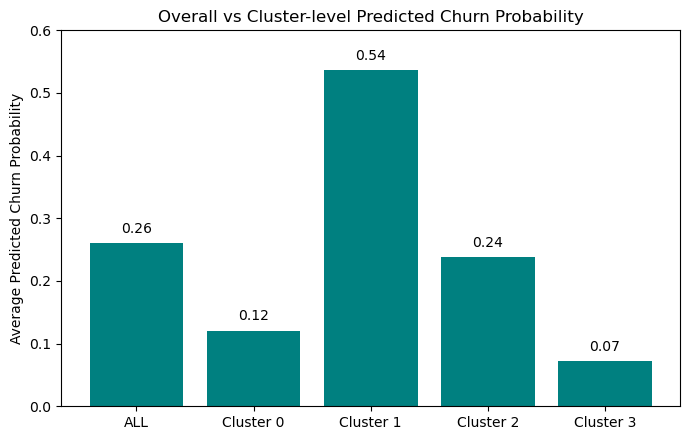

In [157]:
# Overall customer churn data analysis
summary_data.append({"Cluster": "ALL",
    "Avg_Churn_Prob": y_prob_all.mean()})

# Segmented customer churn data analysis
for cid in sorted(labels_series.unique()):
    mask = (labels_series == cid) & (labels_series.index.isin(X_test_all.index))
    if mask.sum() == 0:
        continue
    avg_prob = xgb_all.predict_proba(X_all.loc[mask])[:, 1].mean()
    summary_data.append({
        "Cluster": f"Cluster {cid}",
        "Avg_Churn_Prob": avg_prob})
summary = pd.DataFrame(summary_data)

# Adaptive Y-axis upper limit, enhancing chart readability
y_max_raw = summary["Avg_Churn_Prob"].max()
y_top = np.ceil((y_max_raw + 0.05) * 10) / 10.0
y_top = float(min(0.95, max(0.3, y_top)))
yticks = np.round(np.arange(0.0, y_top + 0.001, 0.1), 2)

# Draw a bar chart.
plt.figure(figsize=(7, 4.5))
bars = plt.bar(summary["Cluster"].astype(str), summary["Avg_Churn_Prob"], color="teal")
plt.ylabel("Average Predicted Churn Probability")
plt.title("Overall vs Cluster-level Predicted Churn Probability")
plt.ylim(0, y_top)
plt.yticks(yticks)

# Mark values at the top of the column
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + y_top*0.02, f"{h:.2f}",
             ha='center', va='bottom')
plt.tight_layout()
plt.show()# Divide the entire training/test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y, test_size=0.3, random_state=42, stratify=y)

# Set the ladder increment model parameters and train the overall prediction model.
xgb_model_all = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1)
xgb_model_all.fit(X_train_all, y_train_all)

# Building a SHAP interpreter
explainer = shap.TreeExplainer(xgb_model_all)

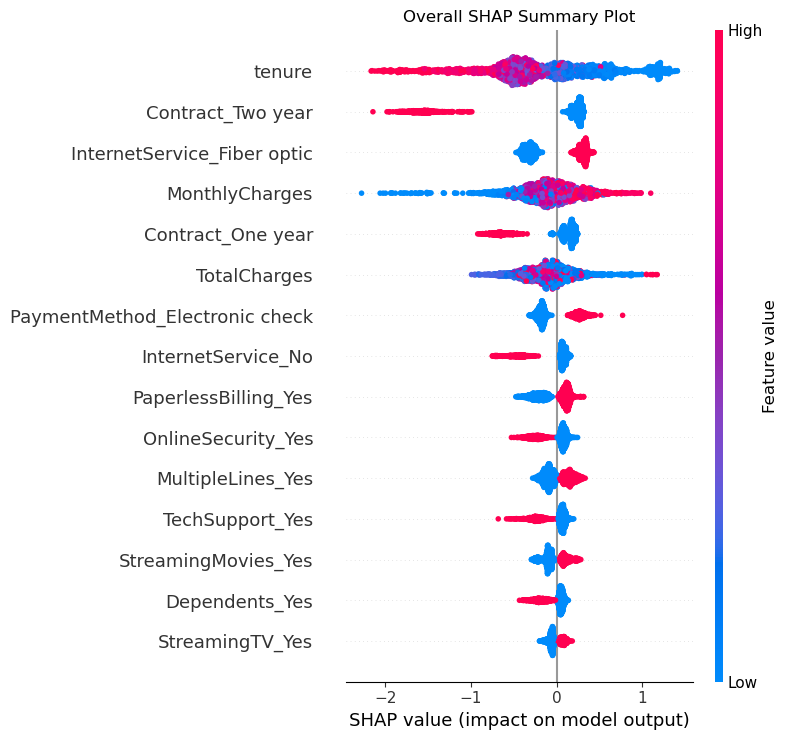

Overall SHAP global feature contribution pie chart：


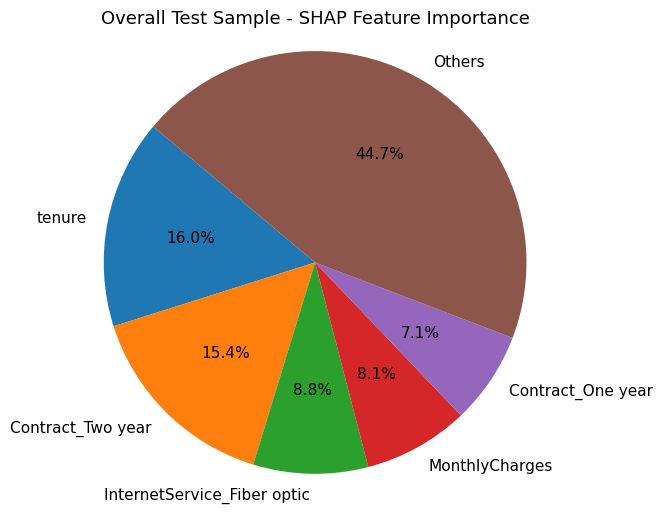


 Cluster 0 SHAP feature contribution pie chart： (Test subset) | sample size=545


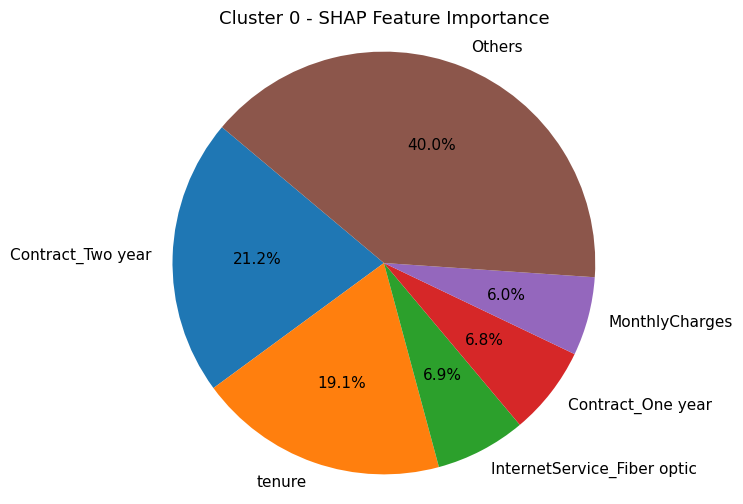


 Cluster 1 SHAP feature contribution pie chart： (Test subset) | sample size=631


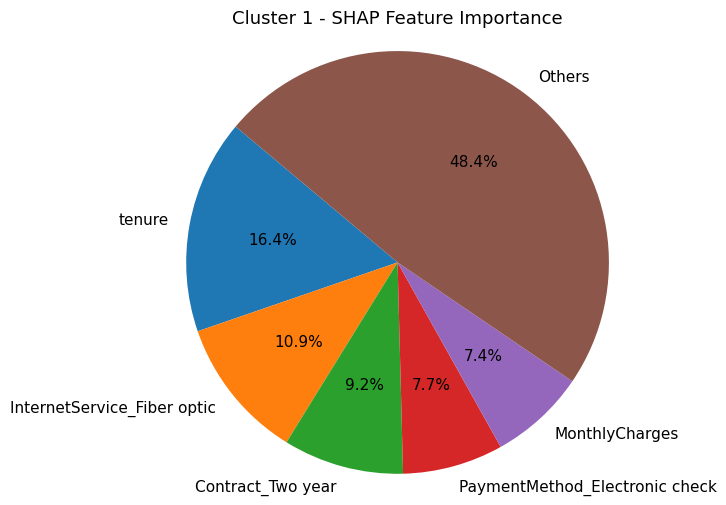


 Cluster 2 SHAP feature contribution pie chart： (Test subset) | sample size=474


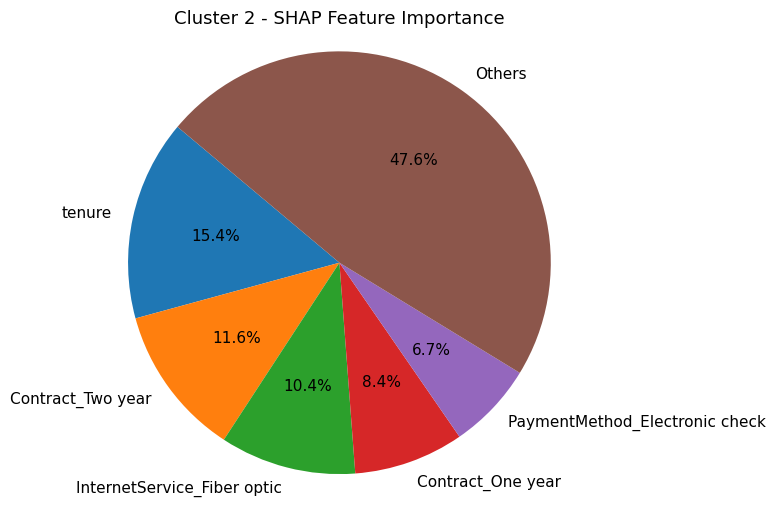


 Cluster 3 SHAP feature contribution pie chart： (Test subset) | sample size=463


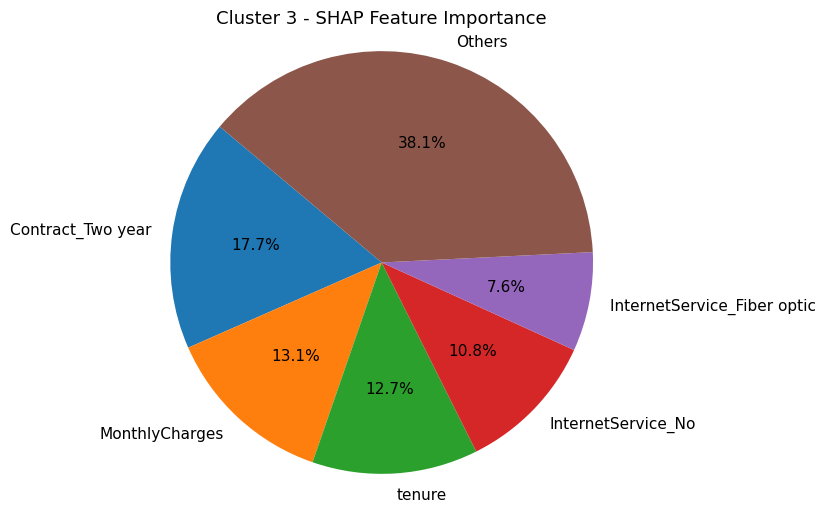


Overall 10 most important SHAP importance scores for the test set：
                          feature  mean_abs_shap
0                          tenure       0.576359
1               Contract_Two year       0.554561
2     InternetService_Fiber optic       0.316320
3                  MonthlyCharges       0.290874
4               Contract_One year       0.254858
5                    TotalCharges       0.230080
6  PaymentMethod_Electronic check       0.213707
7              InternetService_No       0.166253
8            PaperlessBilling_Yes       0.153747
9              OnlineSecurity_Yes       0.129311


In [182]:
# Create a pie chart showing the top five average SHAP values.
def plot_shap_pie(X_input: pd.DataFrame, title_prefix: str = "Overall"):
    """X_input: Data subset used to calculate SHAP importance title_prefix:  Figure caption prefix"""
    shap_values = explainer.shap_values(X_input)  # shape=(n_samples, n_features)
    # Average of each feature | SHAP | as global importance
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_series = pd.Series(mean_abs_shap, index=X_input.columns).sort_values(ascending=False)
#Take the five largest values and other values
    top_k = 5 if len(shap_series) > 5 else len(shap_series)
    top5 = shap_series.head(top_k)
    other_sum = shap_series.iloc[top_k:].sum() if len(shap_series) > top_k else 0.0
    pie_values = list(top5.values) + ([other_sum] if other_sum > 0 else [])
    pie_labels = list(top5.index) + (['Others'] if other_sum > 0 else [])

#Perform chart visualization
    plt.figure(figsize=(6, 6))
    plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=140,
            textprops={'fontsize': 11})
    plt.title(f"{title_prefix} - SHAP Feature Importance", fontsize=13)
    plt.axis('equal')
    plt.show()# Create SHAP Summary Point Map
def plot_shap_summary(X_input: pd.DataFrame, title_prefix: str = "Overall"):
    """
    X_input: Data subset used to calculate SHAP values (DataFrame, column names = feature names)
    title_prefix: Figure caption prefix"""
    shap_values = explainer.shap_values(X_input)  # shape = (n_samples, n_features)
# Drawing beeswarm point plots
    plt.title(f"{title_prefix} SHAP Summary Plot")
    shap.summary_plot(
        shap_values,
        X_input,
        plot_type="dot",
        max_display=15,  # Show the first 15 features
        show=True)

# Drawing SHAP point plots for the entire sample
plot_shap_summary(X_test_all, "Overall")# Overall sample and global SHAP pie chart
print("Overall SHAP global feature contribution pie chart：")
plot_shap_pie(X_test_all, title_prefix="Overall Test Sample")# Iterate through each cluster sample and draw a pie chart to display the results.
test_mask = X_all.index.isin(X_test_all.index)  
labels_series = pd.Series(labels_kmeans, index=X_all.index, name="Cluster")
unique_clusters = sorted(labels_series.unique())
for cid in unique_clusters:
    cid_mask = (labels_series == cid) & test_mask
    X_cluster = X_all.loc[cid_mask]
    if len(X_cluster) < 20:
        # If the number of samples in the test set for a cluster is too small, fall back to the full cluster samples to avoid unstable results.
        X_cluster = X_all.loc[labels_series == cid]
        note = " (ALL samples in cluster, n<20 in test)"
    else:
        note = " (Test subset)"
    if len(X_cluster) == 0:
        continue

    print(f"\n Cluster {cid} SHAP feature contribution pie chart：{note} | sample size={len(X_cluster)}")
    plot_shap_pie(X_cluster, title_prefix=f"Cluster {cid}")

# Define a function: Calculate the Top SHAP importance table for a given subset of data.
def get_shap_importance_table(X_input: pd.DataFrame, topn: int = 10) -> pd.DataFrame:
    sv = explainer.shap_values(X_input)
    mean_abs = np.abs(sv).mean(axis=0)       #Take the absolute value and calculate the average based on characteristics to measure overall importance.
    df_imp = pd.DataFrame({
        "feature": X_input.columns,
        "mean_abs_shap": mean_abs
    }).sort_values("mean_abs_shap", ascending=False).head(topn).reset_index(drop=True)
    return df_imp

# Output the Top-10 SHAP feature importance of the entire test set.
overall_imp = get_shap_importance_table(X_test_all, topn=10)
print("\nOverall 10 most important SHAP importance scores for the test set：")
print(overall_imp)


Permutation Importance for selected features:
                        feature  importance_mean  importance_std
0                        tenure         0.039849        0.007208
16            Contract_Two year         0.013535        0.002568
7   InternetService_Fiber optic         0.010506        0.001595
1                MonthlyCharges         0.003313        0.003954


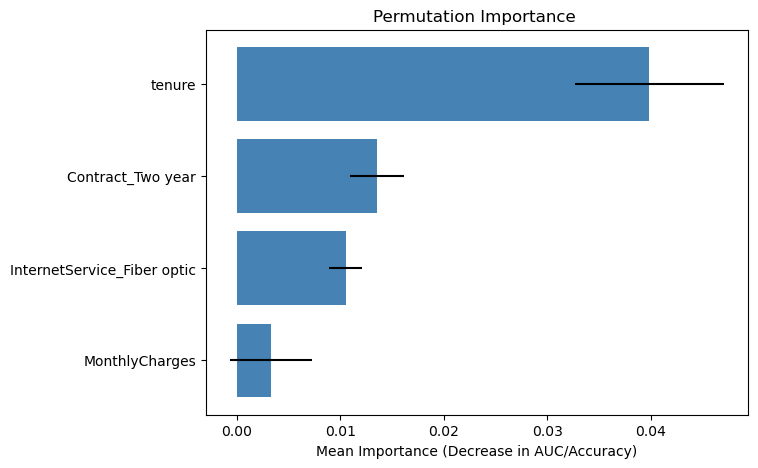

In [188]:
# Based on the SHAP analysis results, specify the features to focus on.
features_to_check = ["tenure", "MonthlyCharges", "Contract_Two year", "InternetService_Fiber optic"]

# Calculate replacement importance
result = permutation_importance(
    xgb_all,            # 已训练好的模型
    X_test_all,         # 测试集特征
    y_test_all,         # 测试集标签
    n_repeats=10,       # 每个特征置换10次，更稳健
    random_state=42,
    n_jobs=-1)

# Organise the results into a DataFrame
perm_imp = pd.DataFrame({
    "feature": X_test_all.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)
perm_imp_selected = perm_imp[perm_imp["feature"].isin(features_to_check)]  # Take the values of the four targets.

print("\nPermutation Importance for selected features:")
print(perm_imp_selected)

# Break it down into bar charts for visual comparison.
plt.figure(figsize=(7,5))
plt.barh(
    perm_imp_selected["feature"],
    perm_imp_selected["importance_mean"],
    xerr=perm_imp_selected["importance_std"],
    color="steelblue")

plt.xlabel("Mean Importance (Decrease in AUC/Accuracy)")
plt.title("Permutation Importance ")
plt.gca().invert_yaxis()  # Put the most important features at the top.
plt.show()
